# My first simulation

As introduction to the `gamdpy` package let us setting up a simulation
of a Lennard-Jones FCC crystal in the constant $NVT$ ensemble.
For a short summary, see the [minimal.py](../examples/minimal.py) example script. Also, the line `sim = gp.get_default_simulation()` will create a simulation object similar to the below.

If `gamdpy` is installed correctly, the following package should be imported without any errors. It is recommended to import the package as `gp`.

In [1]:
import gamdpy as gp

We will also import NumPy for numerical calculations and Matplotlib for plotting.

In [2]:
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting

## Initial particle positions

We wish to set up a configuration of a FCC lattice with $8 \times 8 \times 8$ unit cells, with a density of $\rho = 0.973$. First we create an empty configuration object.

In [3]:
configuration = gp.Configuration(D=3)

Information for a few crystal unit cells are avalible with the `gamdpy` package. For example, the FCC unit cell is stored as `rp.unit_cells.FCC`.

In [4]:
gp.unit_cells.FCC

{'fractional_coordinates': [[0.0, 0.0, 0.0],
  [0.5, 0.5, 0.0],
  [0.5, 0.0, 0.5],
  [0.0, 0.5, 0.5]],
 'lattice_constants': [1.0, 1.0, 1.0]}

We use the `make_lattice` method to assign positions and a simulation box to the  configuration object.

In [5]:
# Setup configuration: FCC Lattice
configuration.make_lattice(
    unit_cell=gp.unit_cells.FCC,
    cells=[8, 8, 8],
    rho=0.973
)

The positions can be accessed with `['r']`. All vector properties, like the positions, are NumPy arrays.

In [6]:
positions = configuration['r']
type(positions)

numpy.ndarray

To confirm that the positions are as expected, we can visualize the configuration using Matplotlib. 

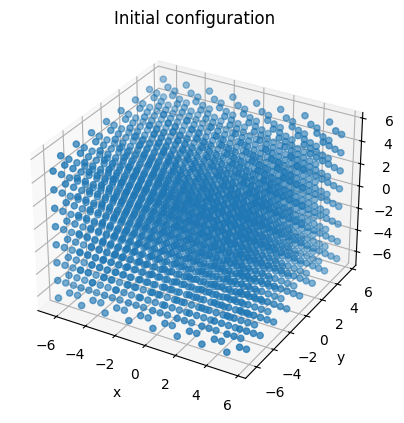

In [7]:
# Make 3D plot using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Initial configuration')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

The configuration object also contains information about the simulation box. The box lengths can be accessed with the `lengths` attribute.

In [8]:
configuration.simbox.lengths  # Box lengths

array([12.815602, 12.815602, 12.815602], dtype=float32)

## Masses and initial velocities

We set all particle masses to one (the value is broadcast to all particles).

In [9]:
configuration['m'] = 1.0  # Set all masses to 1.0

Note that `configuration['m']` refer to an NumPy array. For convenience, we above used a `float` to set all masses to the same value. This value will automatically be broadcast to all particles.

In [10]:
type(configuration['m'])  # configuration['m'] is a NumPy array

numpy.ndarray

After masses are set, we can assign random velocities corresponding to an initial kinetic temperature $T = 0.7$.

In [11]:
temperature = 0.7
configuration.randomize_velocities(temperature=temperature)

To confirm that the initial velocity distribution is as expected, we can compare it the the theoretical Maxwell-Boltzmann distribution.

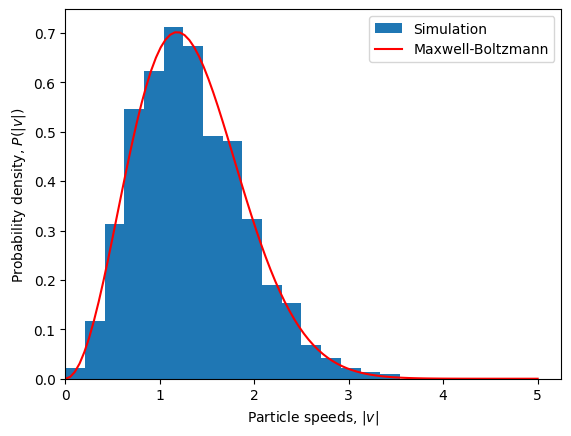

In [12]:
plt.figure()
# Histogram of particle speeds
vel = configuration['v']
speeds = np.linalg.norm(vel, axis=1)
bins = np.linspace(0, 5, 25)
plt.hist(speeds, bins=bins, density=True, label='Simulation')
# Theoretical Maxwell-Boltzmann distribution
v = np.linspace(0, 5, 100)
maxwell_boltzmann = (2*np.pi*temperature)**(-3/2)*4*np.pi*v**2*np.exp(-v**2/(2*temperature))
plt.plot(v, maxwell_boltzmann, label='Maxwell-Boltzmann', color='r')
# Plot settings
plt.xlabel(r'Particle speeds, $|v|$')
plt.ylabel(r'Probability density, $P(|v|)$')
plt.xlim(0, None)
plt.legend()
plt.show()

## Pair potential
Next, we set up the Lennard-Jones pair potential. We use the 12-6 Lennard-Jones potential

$$
  v_\infty(r) = 4\varepsilon \left[\left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6}\right]
$$

(the substript refer to a "truncation" at $\infty$). Here $\sigma$ (`sigma`) is length, and $\varepsilon$ (`epsilon`) is an energy. We will use Lennard-Jones units, where $\sigma = 1$ and $\varepsilon = 1$.

Several pair potentials functions are implemented in `gamdpy`, and the above 12-6 Lennard-Jones potential is implemented as `gp.LJ_12_6_sigma_epsilon`. This is a Python function that takes distances, parameters as input and returns the potential energy, the force and the second derivative of the potential energy.

Let us confirm values are as expected in the minimum of the potential:

\begin{align}
  r_{min} &= 2^{1/6} \\
  v(r_{min}) &= -\varepsilon \\
  f(r_{min}) &= 0 \\
  \left.\frac{d^2v}{dr^2}\right|_{r_{min}} &= (624\cdot2^{-7/3}-168\cdot2^{-4/3})\frac{\varepsilon}{\sigma^2} \simeq 57.146\frac{\varepsilon}{\sigma^2}
\end{align}


In [13]:
pair_func = gp.LJ_12_6_sigma_epsilon  # Pair potential function
r_min = 2**(1/6)
u_min, f_min, curvature_min = pair_func(r_min, (1.0, 1.0, np.inf))
u_min, f_min, curvature_min

(np.float32(-0.99999994), np.float32(-5.6769886e-07), np.float32(57.146423))


To allow for a $O(N)$ algorithm for force calculations, we truncate the pair potential at radius of $r_c = 2.5\sigma$ (`cutoff`). The potential is shifted to zero at the cutoff radius, so the actual potential is

$$
  v(r) = v_\infty(r) - v_\infty(r_c)
$$

For this, we can use `gp.apply_shifted_potential_cutoff` to modify the pair potential.

In [14]:
pair_func = gp.apply_shifted_potential_cutoff(gp.LJ_12_6_sigma_epsilon)

Let us plot the pair potential, so confirm that it looks as we expect.

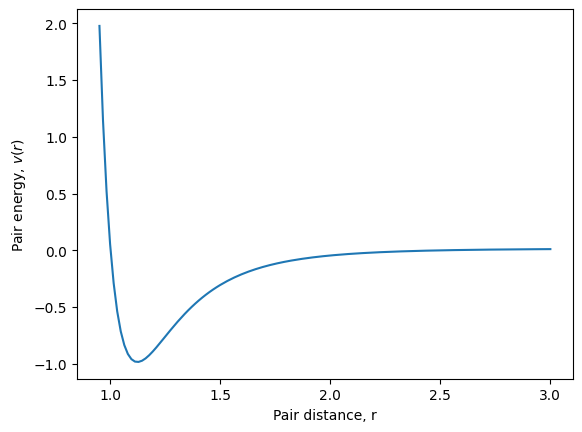

In [15]:
sigma, epsilon, cutoff = 1.0, 1.0, 2.5
pair_distances = np.linspace(0.95, 3.0, 128)
pair_energies = [pair_func(dist, [sigma, epsilon, cutoff])[0] for dist in pair_distances]

plt.figure()
plt.plot(pair_distances, pair_energies)
plt.xlabel(r'Pair distance, r')
plt.ylabel(r'Pair energy, $v(r)$')
plt.show()

We can now create an interaction objects using this pair potential function we made.

In [16]:
pair_pot = gp.PairPotential(pair_func, params=[sigma, epsilon, cutoff], max_num_nbs=1000)

Finally, we create a list will all the interactions in our simulations. In this simulation, we only have one, but later we may want to include more like bonds, walls, or gravity.

In [17]:
interactions = [pair_pot, ]

## Integrator

Next, create an integrator object. These are available in the submodule `gamdpy.integrators`.
Here, we chose to use and implementation of the Nosé-Hoover thermostat discretion using the Leap-Frog scheme (others are available).
We set a time-step of $dt=0.005$ and a thermostat relaxation time to $\tau = 0.2$ (both in Lennard-Jones units).

In [18]:
# Setup integrator: Nosé-Hoover NVT, Leap-frog algorithm
integrator = gp.integrators.NVT(temperature=temperature, tau=0.2, dt=0.005)

## Runtime actions
We typically wants to do some actions during the simulations. Below we specify that we want to store configurations (particle positions, velocities, ...).

* The `gp.TrajectorySaver` does this using a logarithmic timescale in each timeblock.
* The `gp.ScalarSaver` save scalar properties like energy every `steps_between_output=16` timestep.
* During long-time simulations, there might be a drift of the total momentum due to floating point rounding erros. Thus, the `gp.MomentumReset` reset the total momentum every `steps_between_reset=100` timestep. All the runtime actions are collected in a list.

In [19]:
steps_between_output=16
runtime_actions = [
    gp.TrajectorySaver(),
    gp.ScalarSaver(steps_between_output=steps_between_output),
    gp.MomentumReset(steps_between_reset=100),
]


## The Simulation object

We now have all the components to set up a simulation object.

* An configuration object (particle positions, velocities, masses, ...).
* A list of interactions (here the Lennard-Jones potential).
* An integrator object (here the Nosé-Hoover thermostat).
* A list of runtime actions

For the simulation object we also specify that we want `num_timeblocks=32` time blocks of `steps_per_timeblock=1024` steps. We also specify that we want to store the simulation data in `storage=memory`.

In [20]:
# Setup Simulation
sim = gp.Simulation(configuration, interactions, integrator, runtime_actions,
                    num_timeblocks=32,
                    steps_per_timeblock=1024,
                    storage='memory')

**Heads-up**: Data can be stored to the disk for later analysis. This is done by changing `storage='memory'` to something like `storage='LJ_T0.70.h5'` (data is stored in the h5 format).

## Running the simulation

Finally, we run the simulation using the `sim.run_timeblocs` iterator that will loop over all the timeblocs.
Below we print the status of the simulation after each timeblock.

In [21]:
for timeblock in sim.run_timeblocks():
        print(sim.status(per_particle=True))
print(sim.summary())

timeblock= 0     time= 5.120       U= -6.265    W= 0.825     K= 1.051     
timeblock= 1     time= 10.240      U= -6.274    W= 0.768     K= 1.060     
timeblock= 2     time= 15.360      U= -6.258    W= 0.862     K= 1.041     
timeblock= 3     time= 20.480      U= -6.278    W= 0.758     K= 1.046     
timeblock= 4     time= 25.600      U= -6.288    W= 0.700     K= 1.062     
timeblock= 5     time= 30.720      U= -6.280    W= 0.749     K= 1.056     
timeblock= 6     time= 35.840      U= -6.299    W= 0.655     K= 1.045     
timeblock= 7     time= 40.960      U= -6.270    W= 0.794     K= 1.101     
timeblock= 8     time= 46.080      U= -6.262    W= 0.842     K= 1.044     
timeblock= 9     time= 51.200      U= -6.272    W= 0.793     K= 1.062     
timeblock= 10    time= 56.320      U= -6.269    W= 0.792     K= 1.033     
timeblock= 11    time= 61.440      U= -6.267    W= 0.826     K= 1.040     
timeblock= 12    time= 66.560      U= -6.264    W= 0.847     K= 1.049     
timeblock= 13    time= 71

The sim methods prints some basic information after each timeblock and summary.
The output line `Extra time 1.st block ...` indicate that the first timeblock took significant longer than the remaining timeblocks.
This is due to the just in time (JIT) compilation of the Python code to run effectively on GPU's.

## Analysis

We can now analyze the simulation data. Below we extract some thermodynamic quantities stored in the simulation object (more are stored).

In [22]:
# Extract potential energy, virial and kinetic energy
U, W, K = gp.extract_scalars(sim.output, ['U', 'W', 'K'])
type(U)

numpy.ndarray

The variables `U`, `W` and `K` are NumPy arrays with the potential energy, virial and kinetic energy, respectively, for selected timesteps. The number of stored timestep can be found with `len(U)`.

In [23]:
len(U)

2048

Below we compute the times related to when the scalar quantities were stored (in Lennard-Jones units).

In [24]:
dt = sim.integrator.dt  # Time step
steps_between_output = 
time = np.arange(len(U)) * dt * steps_between_output # Time array

SyntaxError: invalid syntax (3699489446.py, line 2)

We can use Matplotlib to plot the potential energy per particle as a function of time. We use `sim.configuration.N` to get the number of particles.

In [ ]:
N = sim.configuration.N  # Number of particles

plt.figure()
plt.plot(time, U/N)
plt.xlabel(r'Time, $t$ [$\sigma\sqrt{m/\varepsilon}$]')  # Time in LJ units
plt.ylabel(r'Potential energy per particle, $U$ [$\varepsilon$]')  # Energy in LJ units
plt.xlim(0, None)
plt.show()

The first part of the simulation show large fluctuations in the potential energy since the system is not yet equilibrated (it was setup in a perfect crystal). Since we are not interested in the equilibration phase, we can discard the fir st timeblock by using the `first_block=1` argument in the `extract_scalars` function. We then need to recalculate the time array.

In [ ]:
U, W, K = gp.extract_scalars(sim.output, ['U', 'W', 'K'], first_block=1)
time = np.arange(len(U)) * dt * sim.output.attrs["steps_between_output"]

plt.figure()
plt.plot(time, U/N, label='Potential energy per particle')
plt.xlabel(r'Time, $t$ [$\sigma\sqrt{m/\varepsilon}$]')  # Time in LJ units
plt.ylabel(r'Energy [$\varepsilon$]')  # Energy in LJ units
plt.legend()
plt.show()

After we have ensured that we have an equilibrium simulation, the expectation value of the potential energy per particle can be found with the `np.mean` NumPy function.

In [ ]:
np.mean(U/N)

In an $NVT$ simulation the pressure is often an important quantity, but is not stored in the simulation data directly. The pressure can be calculated from the virial, $W$. Recall,

$$
  pV = Nk_BT + W
$$

where $p$ is the pressure, $V$ is the volume, $N$ is the number of particles, $k$ is the Boltzmann constant and $T$ is the temperature. The volume can be calculated from the box lengths. In Lennard-Jones units boltzmann constant is $k_B = 1$. Below we use this to calculate the pressure.

In [ ]:
V = sim.configuration.get_volume()  # Volume
dof = 3*N - 3  # Degrees of freedom
T_kin = 2*K/dof  # Kinetic temperature
p = (N*T_kin + W)/V  # Pressure
np.mean(p)  # Mean pressure

## Concluding remarks
Congratulations! You have now set up and executed your first simulation with `gamdpy`.
You are now ready to continue with more advanced simulations and analysis.
For this, we recommend looking at the examples.